**Processo de Leitura do Dataset**

In [261]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, classification_report)
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from scipy.stats import randint
from sklearn.compose import ColumnTransformer
from imblearn.combine import SMOTEENN
from collections import Counter

In [197]:
file_path = "congenital_syphilis_cases/data_set.csv"

data = pd.read_csv(file_path)

In [198]:
file_path = "congenital_syphilis_cases/attributes.csv"

attributes = pd.read_csv(file_path)

**Análise Inicial das Dimensões e Distribuições do Dataset**

In [199]:
data.head(5)

,VDRL_RESULT,CONS_ALCOHOL,RH_FACTOR,SMOKER,PLAN_PREGNANCY,BLOOD_GROUP,HAS_PREG_RISK,TET_VACCINE,IS_HEAD_FAMILY,MARITAL_STATUS,...,HAS_FAM_INCOME,LEVEL_SCHOOLING,CONN_SEWER_NET,NUM_RES_HOUSEHOLD,HAS_FRU_TREE,HAS_VEG_GARDEN,FAM_INCOME,HOUSING_STATUS,WATER_TREATMENT,AGE
0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,5.0,0.0,2.0,1.0,1.0,0.0,1.0,2.0,25.0
1,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,5.0,...,0.0,5.0,0.0,2.0,1.0,1.0,2.0,1.0,3.0,25.0
2,1.0,1.0,2.0,1.0,1.0,4.0,1.0,0.0,1.0,5.0,...,1.0,6.0,2.0,4.0,1.0,1.0,3.0,0.0,3.0,24.0
3,1.0,1.0,2.0,1.0,0.0,4.0,0.0,0.0,1.0,5.0,...,0.0,2.0,1.0,3.0,1.0,1.0,0.0,0.0,2.0,28.0
4,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,1.0,4.0,1.0,3.0,1.0,1.0,0.0,0.0,3.0,27.0


Contagem de Linhas e Colunas

In [200]:
num_rows, num_cols = data.shape

print(f"The CSV contains {num_rows} rows.")
print(f"The CSV contains {num_cols} columns.")

The CSV contains 41762 rows.
The CSV contains 26 columns.


Análise e Separação dos Tipos dos Dados do Dataset

In [201]:
data_types = data.dtypes

data_types_df = pd.DataFrame({
    'Column Name': data_types.index,
    'Data Types': data_types.values
})

data_types_df.to_csv('data_types.csv', index=False)

In [202]:
categorical_columns = []
numerical_columns = []

for index, row in attributes.iterrows():
    if row['Type'] in ['Categorical', 'Binary']:
        categorical_columns.append(row['Attribute'])
    elif row['Type'] == 'Numerical':
        numerical_columns.append(row['Attribute'])

print("Categorical (including Binary):", categorical_columns)
print("Numerical:", numerical_columns)

Categorical (including Binary): ['VDRL_RESULT', 'CONS_ALCOHOL', 'RH_FACTOR', 'SMOKER', 'PLAN_PREGNANCY', 'BLOOD_GROUP', 'HAS_PREG_RISK', 'TET_VACCINE', 'IS_HEAD_FAMILY', 'MARITAL_STATUS', 'FOOD_INSECURITY', 'NUM_ABORTIONS', 'NUM_LIV_CHILDREN', 'NUM_PREGNANCIES', 'FAM_PLANNING', 'TYPE_HOUSE', 'HAS_FAM_INCOME', 'LEVEL_SCHOOLING', 'CONN_SEWER_NET', 'NUM_RES_HOUSEHOLD', 'HAS_FRU_TREE', 'HAS_VEG_GARDEN', 'FAM_INCOME', 'HOUSING_STATUS', 'WATER_TREATMENT']
Numerical: ['AGE']


Análise de Valores Nulos/Faltantes no Dataset

In [203]:
missing_values = data.isnull().sum()
missing_values_percent = (missing_values / len(data)) * 100

missing_data_df = pd.DataFrame({
    'Column Name': missing_values.index,
    'Missing Values': missing_values.values,
    'Missing Values Percentage': missing_values_percent.values
})

missing_data_df.to_csv('missing_data_df.csv', index=False)

In [204]:
not_informed_info = []

columns_to_exclude = ['HAS_FAM_INCOME', 'VDRL_RESULT']
categorical_columns_to_process = [col for col in categorical_columns if col not in columns_to_exclude]

for col in data.columns:
    if col in categorical_columns_to_process:
        max_value = data[col].max()
        not_informed_count = (data[col] == max_value).sum()
    else:
        not_informed_count = data[col].isnull().sum()
    
    not_informed_percent = (not_informed_count / len(data)) * 100
    
    not_informed_info.append({
        'Column Name': col,
        'Missing Values': not_informed_count,
        'Missing Values Percentage': not_informed_percent
    })

not_informed_data_df = pd.DataFrame(not_informed_info)

not_informed_data_df.to_csv('not_informed_values.csv', index=False)


Análise de Linhas Duplicadas no Dataset

In [205]:
duplicated_rows = data.duplicated()

num_duplicated = duplicated_rows.sum()
print(f"Number of duplicate rows: {num_duplicated}")

data_no_duplicates = data.drop_duplicates()

Number of duplicate rows: 833


Análise da Matriz de Correlação

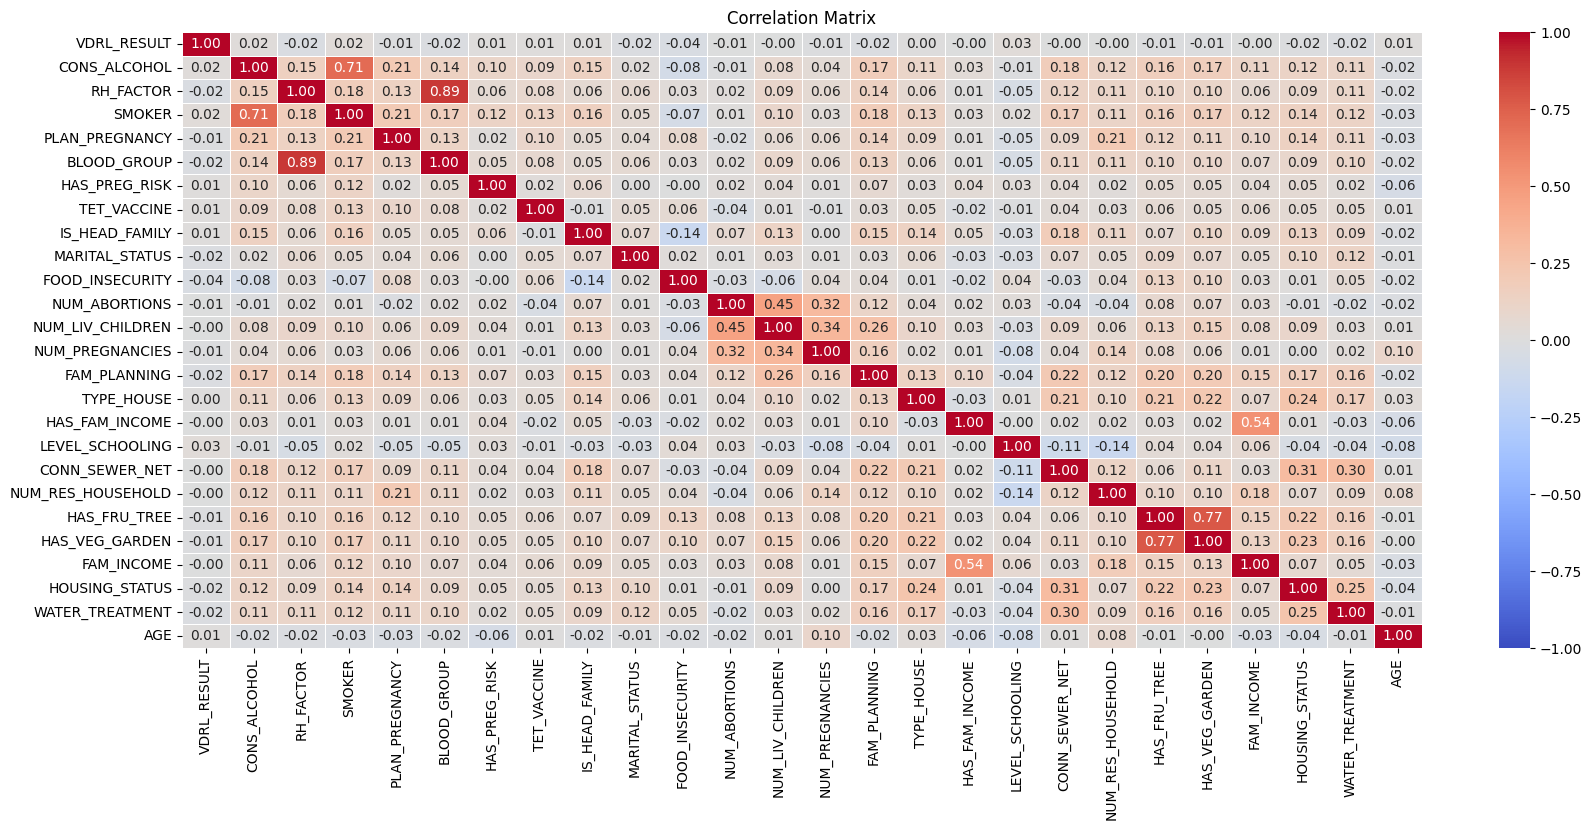

In [206]:
corr_matrix = data[data.columns].corr()

plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f', linewidths=0.5)

plt.title('Correlation Matrix')
plt.show()

Visualização e Análise dos Boxplots das Colunas Numéricas do Dataset

In [207]:
output_dir = 'boxplots'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for col in numerical_columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=data_no_duplicates[col])
    plt.title(f'Boxplot for {col}')
    plt.xlabel(col)
    plt.savefig(os.path.join(output_dir, f'boxplot_{col}.png'))
    plt.close()

Análise da Variabilidade das Colunas Numéricas do Dataset

In [208]:
columns_to_remove = []

for numeric_col in numerical_columns:
    stats = data_no_duplicates[numeric_col].describe()

    print(f"\n{stats}\n")

    mean = data_no_duplicates[numeric_col].mean()
    std_dev = data_no_duplicates[numeric_col].std()
    coef_of_variation = std_dev / abs(mean)
    
    print(f"Coefficient of variation for {numeric_col}: {coef_of_variation:.4f}")

    if coef_of_variation < 0.1 or coef_of_variation > 0.55:
        print(f"The column {numeric_col} has low variability.")
        columns_to_remove.append(numeric_col)
    else:
        print(f"The column {numeric_col} has sufficient variability.")

df_cleaned = data_no_duplicates.drop(columns=columns_to_remove)

print(f"\nRemoved columns: {columns_to_remove}")



count    40929.000000
mean        25.185858
std          4.576384
min         -3.000000
25%         25.000000
50%         25.000000
75%         25.000000
max         51.000000
Name: AGE, dtype: float64

Coefficient of variation for AGE: 0.1817
The column AGE has sufficient variability.

Removed columns: []


Visualização e Análise dos Histogramas das Colunas Categóricas e Binárias do Dataset

In [209]:
output_dir = 'histograms'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for col in categorical_columns:
    plt.figure(figsize=(8, 6))
    sns.countplot(x=df_cleaned[col])
    plt.title(f'Histogram for {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45) 
    plt.savefig(os.path.join(output_dir, f'histogram_{col}.png'))
    plt.close()

Análise da Variabilidade das Colunas Categóricas e Binárias do Dataset

In [210]:
columns_to_remove = []

for categorical_col in categorical_columns:

    if categorical_col == 'VDRL_RESULT' or categorical_col == 'SMOKER':
        continue

    value_counts = df_cleaned[categorical_col].value_counts(normalize=True) * 100

    print(f"\n{value_counts}\n")

    max_value_proportion = value_counts.max()

    if max_value_proportion > 85:
        print(f"The column {categorical_col} has a dominant category (>85%)")
        columns_to_remove.append(categorical_col)
    else:
        print(f"The column {categorical_col} has sufficient variability.")

df_cleaned = df_cleaned.drop(columns=columns_to_remove)

print(f"\nRemoved columns: {columns_to_remove}")


CONS_ALCOHOL
1.0    87.155806
2.0     9.797454
0.0     3.046739
Name: proportion, dtype: float64

The column CONS_ALCOHOL has a dominant category (>85%)

RH_FACTOR
0.0    61.704415
2.0    33.108554
1.0     5.187031
Name: proportion, dtype: float64

The column RH_FACTOR has sufficient variability.

PLAN_PREGNANCY
1.0    54.758240
0.0    40.372352
2.0     4.869408
Name: proportion, dtype: float64

The column PLAN_PREGNANCY has sufficient variability.

BLOOD_GROUP
4.0    32.939969
0.0    31.342080
1.0    24.786826
2.0     8.338831
3.0     2.592294
Name: proportion, dtype: float64

The column BLOOD_GROUP has sufficient variability.

HAS_PREG_RISK
1.0    82.550270
0.0    12.719588
2.0     4.730142
Name: proportion, dtype: float64

The column HAS_PREG_RISK has sufficient variability.

TET_VACCINE
0.0    88.054924
1.0     7.495908
2.0     4.449168
Name: proportion, dtype: float64

The column TET_VACCINE has a dominant category (>85%)

IS_HEAD_FAMILY
1.0    74.983508
0.0    14.566689
2.0    1

Remoção de Colunas

In [211]:
# 'NUM_ABORTIONS', 'NUM_LIV_CHILDREN' --> Quantidade de Nulos 
# 'HAS_FRU_TREE', 'HAS_VEG_GARDEN' --> Desconectado do propósito do dataset
# 'RH_FACTOR', 'BLOOD_GROUP' --> Tem alta correlação entre si e fogem do propósito do dataset
# 'FAM_INCOME' --> correlação alta com HAS_FAM_INCOME e ela tem correlação maior com o alvo de idade

columns_to_remove = ['RH_FACTOR', 'BLOOD_GROUP', 'HAS_FRU_TREE', 'HAS_VEG_GARDEN', 'NUM_ABORTIONS', 'NUM_LIV_CHILDREN', 'FAM_INCOME']

df_cleaned = df_cleaned.drop(columns=columns_to_remove)

df_cleaned

,VDRL_RESULT,SMOKER,PLAN_PREGNANCY,HAS_PREG_RISK,IS_HEAD_FAMILY,MARITAL_STATUS,FOOD_INSECURITY,NUM_PREGNANCIES,FAM_PLANNING,HAS_FAM_INCOME,LEVEL_SCHOOLING,CONN_SEWER_NET,NUM_RES_HOUSEHOLD,HOUSING_STATUS,WATER_TREATMENT,AGE
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,2.0,1.0,2.0,25.0
1,1.0,1.0,1.0,1.0,1.0,5.0,0.0,1.0,1.0,0.0,5.0,0.0,2.0,1.0,3.0,25.0
2,1.0,1.0,1.0,1.0,1.0,5.0,2.0,1.0,0.0,1.0,6.0,2.0,4.0,0.0,3.0,24.0
3,1.0,1.0,0.0,0.0,1.0,5.0,2.0,3.0,0.0,0.0,2.0,1.0,3.0,0.0,2.0,28.0
4,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,4.0,1.0,3.0,0.0,3.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41757,1.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,3.0,1.0,4.0,0.0,3.0,25.0
41758,1.0,1.0,1.0,1.0,1.0,5.0,2.0,4.0,1.0,1.0,4.0,0.0,3.0,0.0,0.0,15.0
41759,1.0,1.0,0.0,1.0,1.0,5.0,2.0,4.0,1.0,1.0,4.0,0.0,3.0,0.0,0.0,23.0
41760,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,3.0,2.0,2.0,25.0


**Modelos de Regressão**

Duplicação do Dataset Cleaned para Criar um Exclusivo para Trabalhar a Regressão 

In [212]:
df_regression = df_cleaned

df_regression

,VDRL_RESULT,SMOKER,PLAN_PREGNANCY,HAS_PREG_RISK,IS_HEAD_FAMILY,MARITAL_STATUS,FOOD_INSECURITY,NUM_PREGNANCIES,FAM_PLANNING,HAS_FAM_INCOME,LEVEL_SCHOOLING,CONN_SEWER_NET,NUM_RES_HOUSEHOLD,HOUSING_STATUS,WATER_TREATMENT,AGE
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,2.0,1.0,2.0,25.0
1,1.0,1.0,1.0,1.0,1.0,5.0,0.0,1.0,1.0,0.0,5.0,0.0,2.0,1.0,3.0,25.0
2,1.0,1.0,1.0,1.0,1.0,5.0,2.0,1.0,0.0,1.0,6.0,2.0,4.0,0.0,3.0,24.0
3,1.0,1.0,0.0,0.0,1.0,5.0,2.0,3.0,0.0,0.0,2.0,1.0,3.0,0.0,2.0,28.0
4,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,4.0,1.0,3.0,0.0,3.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41757,1.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,3.0,1.0,4.0,0.0,3.0,25.0
41758,1.0,1.0,1.0,1.0,1.0,5.0,2.0,4.0,1.0,1.0,4.0,0.0,3.0,0.0,0.0,15.0
41759,1.0,1.0,0.0,1.0,1.0,5.0,2.0,4.0,1.0,1.0,4.0,0.0,3.0,0.0,0.0,23.0
41760,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,3.0,2.0,2.0,25.0


Remoção de Erros Amostrais onde a Idade é Inválida

In [213]:
filtered_cases = df_regression[df_regression['AGE'] < 10]
count_cases = len(filtered_cases)

print(f"{count_cases} cases found, where AGE is less than 10:")
print(filtered_cases[['AGE']].head(15))

42 cases found, where AGE is less than 10:
       AGE
996    3.0
2246   0.0
2247   3.0
2684   0.0
4452   4.0
4453   0.0
8282   1.0
8320   2.0
8617   7.0
11323  0.0
11938  0.0
11939 -3.0
12277  0.0
14273  1.0
16715  0.0


In [214]:
initial_count = len(df_regression)

df_regression = df_regression[df_regression['AGE'] >= 10]

final_count = len(df_regression)

print(f"Number of rows before removal: {initial_count}")
print(f"Number of rows after removal: {final_count}")

Number of rows before removal: 40929
Number of rows after removal: 40887


Análise da Importância das Variáveis para o Modelo de Random Forest Regressor

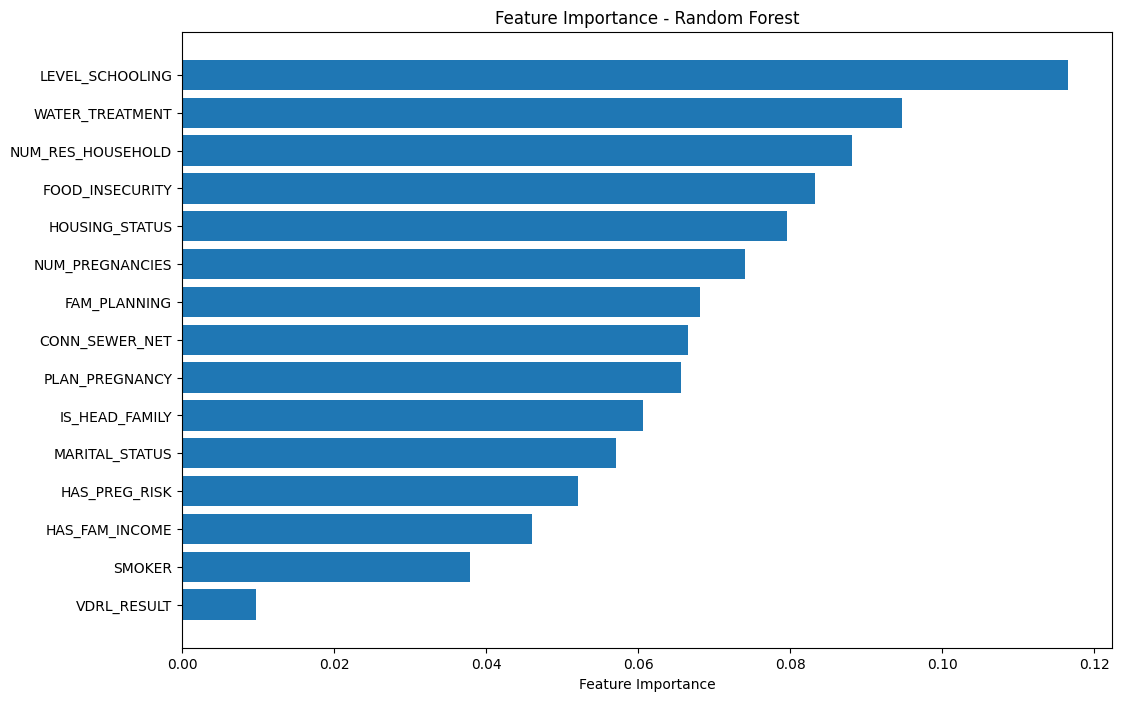

In [215]:
X = df_regression.drop(columns=['AGE'])
y = df_regression['AGE']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feature_names = X.columns

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Feature Importance')
plt.title('Feature Importance - Random Forest')
plt.gca().invert_yaxis()
plt.show()

Aplicação do Random Forest Regressor com as Top 10 Features

In [ ]:
top_n = 10
top_features = feature_importances['Feature'].head(top_n).tolist()
print(f"Top {top_n} features: {top_features}")

X = df_regression[top_features]
y = df_regression['AGE']

X_encoded = pd.get_dummies(X)

X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

param_dist = {
    'n_estimators': randint(50, 200),      # Número de árvores na floresta
    'max_depth': randint(5, 20),           # Profundidade máxima das árvores
    'min_samples_split': randint(2, 10),   # Mínimo de amostras para dividir um nó
    'min_samples_leaf': randint(1, 5),     # Mínimo de amostras em uma folha
    'max_features': ['sqrt', 'log2']       # Máximo de variáveis a serem consideradas em cada divisão
}

#RandomizedSearchCV é mais indicado devido ao numero de hiperparâmetros possíveis, e uma busca completa com GridSearchCV pode ser muito demorada.
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=20,  # Número de combinações a testar
    cv=5,       # Validação cruzada com 5 folds
    scoring='r2',
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_top, y_train_top)

print("Best Hyperparameters:", random_search.best_params_)

best_rf = random_search.best_estimator_
y_pred_top = best_rf.predict(X_test_top)

Top 10 features: ['LEVEL_SCHOOLING', 'WATER_TREATMENT', 'NUM_RES_HOUSEHOLD', 'FOOD_INSECURITY', 'HOUSING_STATUS', 'NUM_PREGNANCIES']
Best Hyperparameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 98}


In [230]:
mse_top = mean_squared_error(y_test_top, y_pred_top)
mae_top = mean_absolute_error(y_test_top, y_pred_top)
mape_top = (abs((y_test_top - y_pred_top) / y_test_top).mean()) * 100

print(f"Mean Absolute Error (MAE) with top {top_n} features: {mae_top}")
print(f"Mean Squared Error (MSE) with top {top_n} features: {mse_top}")
print(f"Mean Absolute Percentage Error (MAPE) with top {top_n} features: {mape_top:.2f}%")

Mean Absolute Error (MAE) with top 10 features: 2.875565787177438
Mean Squared Error (MSE) with top 10 features: 17.756230293237966
Mean Absolute Percentage Error (MAPE) with top 10 features: 11.98%


Aplicação do Random Forest Regressor com Todas as Features do Dataset após a EDA

In [218]:
X = df_regression.drop(columns=['AGE'])
y = df_regression['AGE']                

X_encoded = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

rf = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': randint(50, 200),      # Número de árvores na floresta
    'max_depth': randint(5, 20),           # Profundidade máxima das árvores
    'min_samples_split': randint(2, 10),   # Mínimo de amostras para dividir um nó
    'min_samples_leaf': randint(1, 5),     # Mínimo de amostras em uma folha
    'max_features': ['sqrt', 'log2']       # Máximo de variáveis a serem consideradas em cada divisão
}

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,  # Número de combinações a testar
    cv=5,       # Validação cruzada com 5 folds
    scoring='r2',
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)

print("Best Hyperparameters:", random_search.best_params_)

best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test)


Best Hyperparameters: {'max_depth': 18, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 139}


In [219]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mape = (np.abs((y_test - y_pred) / y_test).mean()) * 100
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 2.85171239477885
Mean Squared Error (MSE): 17.08729262300909
Mean Absolute Percentage Error (MAPE): 11.86%


Análise do Modelo de KNN Regressor

In [ ]:
X = df_regression.drop(columns=['AGE'])
y = df_regression['AGE']

X_encoded = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

param_grid = {
    'n_neighbors': list(range(1, 21)),       # Testar n_neighbors de 1 a 20
    'weights': ['uniform', 'distance'],       # Testar diferentes estratégias de ponderação
    'metric': ['euclidean', 'manhattan']      # Testar diferentes métricas de distância
}

knn = KNeighborsRegressor()

grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=5,                   # 5-fold cross-validation
    scoring='r2',           # Métrica de avaliação
    n_jobs=-1,              # Utilizar todos os núcleos disponíveis
    verbose=1               # Exibir informações durante a execução
)

grid_search.fit(X_train, y_train)

print(f"Best Hyperparameters: {grid_search.best_params_}")

best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best Hyperparameters: {'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'uniform'}


In [221]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = (np.abs((y_test - y_pred) / y_test).mean()) * 100

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 2.9625091709464417
Mean Squared Error (MSE): 18.056950966006358
Mean Absolute Percentage Error (MAPE): 12.29%


**Modelos de Classificação**

Duplicação do Dataset Cleaned para Criar um Exclusivo para Trabalhar a Classificação

In [254]:
df_classification = df_cleaned

df_classification

,VDRL_RESULT,SMOKER,PLAN_PREGNANCY,HAS_PREG_RISK,IS_HEAD_FAMILY,MARITAL_STATUS,FOOD_INSECURITY,NUM_PREGNANCIES,FAM_PLANNING,HAS_FAM_INCOME,LEVEL_SCHOOLING,CONN_SEWER_NET,NUM_RES_HOUSEHOLD,HOUSING_STATUS,WATER_TREATMENT,AGE
0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,4.0,0.0,0.0,5.0,0.0,2.0,1.0,2.0,25.0
1,1.0,1.0,1.0,1.0,1.0,5.0,0.0,1.0,1.0,0.0,5.0,0.0,2.0,1.0,3.0,25.0
2,1.0,1.0,1.0,1.0,1.0,5.0,2.0,1.0,0.0,1.0,6.0,2.0,4.0,0.0,3.0,24.0
3,1.0,1.0,0.0,0.0,1.0,5.0,2.0,3.0,0.0,0.0,2.0,1.0,3.0,0.0,2.0,28.0
4,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,4.0,1.0,3.0,0.0,3.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41757,1.0,1.0,0.0,1.0,1.0,0.0,0.0,3.0,0.0,1.0,3.0,1.0,4.0,0.0,3.0,25.0
41758,1.0,1.0,1.0,1.0,1.0,5.0,2.0,4.0,1.0,1.0,4.0,0.0,3.0,0.0,0.0,15.0
41759,1.0,1.0,0.0,1.0,1.0,5.0,2.0,4.0,1.0,1.0,4.0,0.0,3.0,0.0,0.0,23.0
41760,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,2.0,0.0,3.0,2.0,2.0,25.0


Remoção das Linhas com Idades Inválidas Retiradas Anteriormente 

In [255]:
filtered_cases = df_classification[df_classification['AGE'] < 10]
count_cases = len(filtered_cases)

print(f"{count_cases} cases found, where AGE is less than 10:")

initial_count = len(df_classification)

df_classification = df_classification[df_classification['AGE'] >= 10]

final_count = len(df_classification)

print(f"Number of rows before removal: {initial_count}")
print(f"Number of rows after removal: {final_count}")

42 cases found, where AGE is less than 10:
Number of rows before removal: 40929
Number of rows after removal: 40887


Análise do Balanceamento dos Dados da Coluna VDRL_RESULT

In [256]:
counts = df_classification['VDRL_RESULT'].value_counts()

print(f"Number of 0s: {counts.get(0, 0)}")
print(f"Number of 1s: {counts.get(1, 0)}")

Number of 0s: 820
Number of 1s: 40067


In [259]:
# 1. Separar variáveis independentes (X) e alvo (y)
X = df_classification.drop(columns=['VDRL_RESULT'])
y = df_classification['VDRL_RESULT']  # Variável binária

# Identificar colunas categóricas e numéricas
categorical_columns = [col for col in X.columns if col != 'AGE']
numerical_columns = ['AGE']

# 2. Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Configurar o pré-processamento
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),  # Escalonar AGE
        ('cat', OneHotEncoder(drop='first'), categorical_columns)  # One-Hot Encoding para categóricas
    ]
)

# Pré-processar os dados antes de aplicar SMOTEENN
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# 4. Aplicar SMOTEENN no conjunto de treinamento
smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X_train_preprocessed, y_train)

In [262]:
print(f"Original dataset distribution: {Counter(y_train)}")
print(f"Resampled dataset distribution: {Counter(y_resampled)}")

Original dataset distribution: Counter({1.0: 32053, 0.0: 656})
Resampled dataset distribution: Counter({0.0: 31572, 1.0: 27024})


In [ ]:
# 1. Configurar os hiperparâmetros para a busca
param_dist = {
    'n_estimators': randint(50, 200),        # Número de árvores na floresta
    'max_depth': [None, 10, 20],             # Profundidade máxima
    'min_samples_split': randint(2, 10),    # Mínimo de amostras para dividir um nó
    'min_samples_leaf': randint(1, 5),      # Mínimo de amostras em uma folha
    'max_features': ['sqrt', 'log2']        # Máximo de variáveis a serem consideradas
}

# 2. Configurar o RandomizedSearchCV com validação cruzada
rf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=20,              # Número de combinações aleatórias a testar
    scoring='accuracy',
    cv=5,                   # Validação cruzada com 5 folds
    n_jobs=-1,
    verbose=1,
    random_state=42
)

# 3. Treinar o modelo com os dados balanceados
random_search.fit(X_resampled, y_resampled)

# 4. Exibir os melhores hiperparâmetros
best_params = random_search.best_params_
print(f"Best Hyperparameters: {best_params}")

# 5. Avaliar o modelo no conjunto de teste
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test_preprocessed)

# 6. Documentar as métricas de desempenho
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# 7. Calcular a curva ROC
y_pred_proba = best_rf.predict_proba(X_test_preprocessed)[:, 1]  # Probabilidade para a classe positiva
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid()
plt.show()

# 8. Interpretar o impacto das variáveis (Feature Importance)
importances = best_rf.feature_importances_
feature_names = preprocessor.get_feature_names_out()

feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Visualizar as importâncias das features
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance - Random Forest')
plt.gca().invert_yaxis()
plt.show()

print("Top Features Influencing the Model:")
print(feature_importances.head())

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [236]:
print(accuracy)
print(precision)
print(recall)
print(f1)

0.9799657952602003
0.9799657952602003
1.0
0.9898815399802566
